In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

from wordcloud import WordCloud

%matplotlib inline

import os

from collections import defaultdict


### READING ANIMELIST.CSV

In [4]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [6]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
len(rating_df)

8000000

### DATA PROCESSING

In [11]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [12]:
len(rating_df)

5221355

In [14]:
min_rating = min(rating_df["rating"])
min_rating

0

In [15]:
max_rating = max(rating_df["rating"])
max_rating

10

In [17]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.090100941230772)

In [18]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [19]:
rating_df.duplicated().sum()

np.int64(0)

In [20]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### Encoding User_Id

In [25]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [27]:
n_users = len(user2user_encoded)
n_users

6686

#### Encoding Anime ID

In [28]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)


In [29]:
n_anime = len(anime2anime_encoded)
n_anime

17554

#### Reset Indexes to introduce randomness

In [30]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [31]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,10195,30749,0.8,2541,1229
1,23663,34914,0.0,6035,3403
2,3466,34566,0.3,856,1028
3,10793,39551,0.0,2704,1669
4,890,6904,0.5,241,2980


In [32]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values

#### Splitting Data for training and testing

In [33]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [34]:
X_train, X_test, y_train, y_test = (X[:train_indices], X[train_indices:],
                                    y[:train_indices], y[train_indices:])

In [35]:
len(X_train), len(X_test), len(y_train), len(y_test)

(5220355, 1000, 5220355, 1000)

In [36]:
type(X_train)

numpy.ndarray

In [39]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]


In [40]:
type(X_train_array)

list

### MODEL ARCHITECTURE

In [41]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", optimizer='Adam', metrics=["mae", "mse"])
    return model


In [43]:
model = RecommenderNet()

In [44]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    855,808 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,912 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,102,726 (11.84 MB)

 Trainable params: 3,102,724 (11.84 MB)

 Non-trainable params: 2 (8.00 B)

In [45]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:     
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr

In [47]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=1)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint =  ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min", restore_best_weights=True)

In [48]:
my_callbacks = [lr_callback, model_checkpoint, early_stopping]

In [49]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks,

)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.7815 - mae: 0.3789 - mse: 0.1914 - val_loss: 0.7380 - val_mae: 0.3761 - val_mse: 0.1784 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - loss: 0.7774 - mae: 0.3775 - mse: 0.1898 - val_loss: 0.7822 - val_mae: 0.3830 - val_mse: 0.1944 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.7702 - mae: 0.3750 - mse: 0.1869 - val_loss: 0.7781 - val_mae: 0.3822 - val_mse: 0.1928 - learning_rate: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/20
523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.7598 - mae: 0.3713 - mse: 0.1828 - val_loss: 0.7708 - val_mae: 0.3804 - val_mse: 0.1900 -

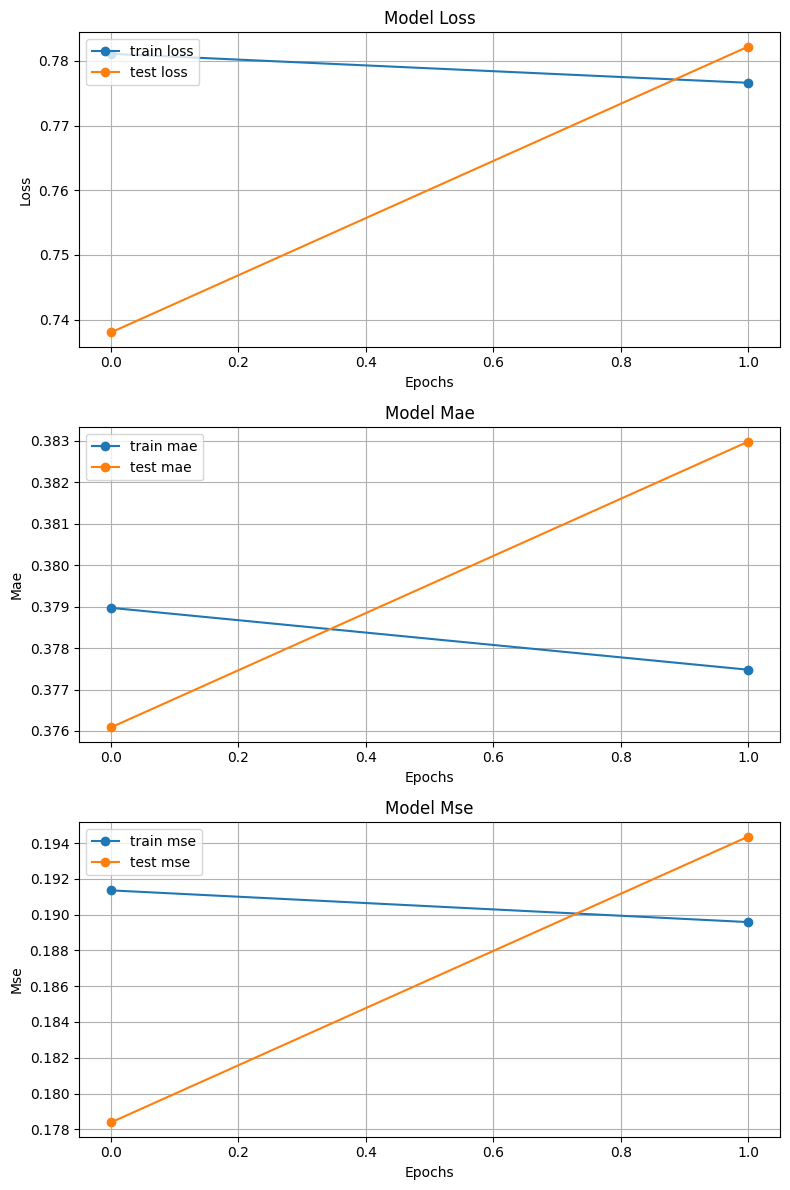

In [50]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize = (8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric.capitalize())
    ax.legend(loc="upper left")
    ax.grid()

plt.tight_layout()
plt.show()

In [53]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights
    

In [54]:
anime_weights = extract_weights("anime_embedding", model)

In [55]:
user_weights = extract_weights("user_embedding", model)

### READING ANIME.CSV

In [57]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [58]:
df = df.replace("Unknown", np.nan)


In [62]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

    except:
        print("Anime not found")
    return name

In [63]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [65]:
getAnimeName(6702)

'Fairy Tail'

In [66]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [67]:
df = df[["anime_id", "eng_version", "Score","Genres", "Episodes", "Type", "Premiered", "Members"]]

In [68]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [69]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [70]:
getAnimeFrame(6702, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4707,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",175,TV,Fall 2009,1312470


In [76]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV

In [79]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [80]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [86]:
def getSynopsis(anime, synopsis_df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [87]:
getSynopsis(23, synopsis_df)

"In order to fulfill their dead father's wish, the siblings, Takane Kiku and Takane Ryuji aims for the champopn title of the boxing arena. The sister, Kiku, will act as the trainer while her brother, Ryuji, will concentrate on the role of the boxer and learn the Boomerang. His battle with many rivals has led to the growth and maturity of Ryuji. The junior high boxing tournament has began and Ryuji will be fighting with his arch-rival, Kenzaki Jun. The battle begins. (Source: ANN)"

In [88]:
getSynopsis("Steins;Gate", synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

## CONTENT/ITEM BASED RECOMMENDATION

In [89]:
pd.set_option("max_colwidth", None)

In [162]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, 
                        df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dicts = np.argsort(dists)

        n = n + 1  # include the query anime itself

        if neg:
            closest = sorted_dicts[:n]
        else:
            closest = sorted_dicts[-n:][::-1]  # descending order


        if return_dist:
            return dists, closest

        similarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            if decoded_id == index:
                continue  # skip self-match

            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            anime_genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            similarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "genre": anime_genre,
                "similarity": similarity,
            })

        Frame = pd.DataFrame(similarityArr).sort_values(by=["similarity"], ascending=False)
        return Frame
    except Exception as e:
        print("Error occurred:", e)
        return None


In [155]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    n=2
)

Anime closest to Steins;Gate


,anime_id,name,genre,similarity
0,35191,Free! Movie 2: Timeless Medley - Yakusoku,"School, Slice of Life, Sports",0.322734
1,244,Agatha Christie's Great Detectives Poirot and Marple,"Historical, Mystery",0.320746


### USER BASED RECOMMENDATION

In [120]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"User '{index}' not found in encoding dictionary.")

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dict = np.argsort(dists)

        n = n + 1  # to include the input user

        if neg:
            closest = sorted_dict[:n]
        else:
            closest = sorted_dict[-n:][::-1]  # descending order

        if return_dist:
            return dists, closest

        similarityArr = []

        for close in closest:
            decoded_id = user2user_decoded.get(close)

            if decoded_id == index:
                continue  # skip self-match

            similarity = dists[close]

            similarityArr.append({
                "similar_users": decoded_id,
                "similarity": similarity
            })

        similar_users = pd.DataFrame(similarityArr).sort_values(by=["similarity"], ascending=False)
        return similar_users

    except Exception as e:
        print("Error occurred:", e)
        return None


In [122]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation="bilinear")

In [128]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []

    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)

    return genres_list

In [132]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,10195,30749,0.8,2541,1229
1,23663,34914,0.0,6035,3403
2,3466,34566,0.3,856,1028
3,10793,39551,0.0,2704,1669
4,890,6904,0.5,241,2980


In [134]:
def get_user_preferences(user_id, rating_df ,df , plot=False):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]
    users_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= users_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows

In [150]:
def get_user_recommendations(similar_users, user_pref, df, rating_df, synopsis_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(user_id, rating_df, df)

        pref_list = pref_list[~pref_list["eng_version"].isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
        
    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name, str):
                frame = getAnimeFrame(anime_name, df)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id), synopsis_df)

                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": synopsis
                })
    return pd.DataFrame(recommended_animes).head(n)

In [151]:
similar_users = find_similar_users(int(11880),
                   user_weights,
                   user2user_encoded,
                   user2user_decoded
                  )

In [152]:
user_pref = get_user_preferences(11880, rating_df, df, plot=False)

In [153]:
get_user_recommendations(similar_users, user_pref, df, rating_df, synopsis_df, n=10)

,n,anime_name,Genres,Synopsis
0,9,Toradora!,"Slice of Life, Comedy, Romance, School","uuji Takasu is a gentle high school student with a love for housework; but in contrast to his kind nature, he has an intimidating face that often gets him labeled as a delinquent. On the other hand is Taiga Aisaka, a small, doll-like student, who is anything but a cute and fragile girl. Equipped with a wooden katana and feisty personality, Taiga is known throughout the school as the ""Palmtop Tiger."" One day, an embarrassing mistake causes the two students to cross paths. Ryuuji discovers that Taiga actually has a sweet side: she has a crush on the popular vice president, Yuusaku Kitamura, who happens to be his best friend. But things only get crazier when Ryuuji reveals that he has a crush on Minori Kushieda—Taiga's best friend! Toradora! is a romantic comedy that follows this odd duo as they embark on a quest to help each other with their respective crushes, forming an unlikely alliance in the process."
1,9,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
2,8,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
3,7,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peac

### HYBRID RECOMMENDER SYSTEM

In [163]:
def hybrid_recommendation(user_id, user_weight=0.4, content_weight=0.6):

    # User-based Recommendation
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, rating_df, synopsis_df)

    user_recommended_animes_list = user_recommended_animes["anime_name"].tolist()

    #Content-based Recommendation
    content_recommended_animes = []

    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df)
       
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found for: {anime}")

    combined_scores = {}

    for anime in user_recommended_animes_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]



In [164]:
hybrid_recommendation(15597)

['That Time I Got Reincarnated as a Slime Season 2 Episode 24.9 – Digression:Hinata Sakaguchi',
 'Coffee Tadaiku',
 'Neko Hiki no Oruorane',
 'Wave!!: Surfing Yappe!!',
 'Riki-Oh 2:Child of Destruction',
 'Tsuyokiss',
 'School Days: Magical Heart Kokoro-chan',
 'Micchiri Neko March',
 'The Illusionary Golden Bowl',
 'Amakano']